In [1]:
"""Analyze Boltz affinity predictions for protein-compound pairs."""
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Boltz Affinity Prediction Analysis

This notebook analyzes the Boltz affinity predictions for the top 10 protein-compound pairs from CysDB and mol_glue datasets.

## 1. Load Original Predictions

Load the original prediction CSVs to get protein sequences, SMILES, and predicted pChEMBL values.

In [2]:
# Load prediction datasets
df_cysdb = pd.read_csv('cysdb_predictions.csv')
df_mol_glue = pd.read_csv('mol_glue_predictions.csv')

# Sort by predicted pChEMBL (descending)
df_cysdb = df_cysdb.sort_values(by='Predicted pChEMBL', ascending=False)
df_mol_glue = df_mol_glue.sort_values(by='Predicted pChEMBL', ascending=False)

# Get top 10 predictions for each protein
top10_cysdb = df_cysdb.groupby('Sequence').head(10).copy()
top10_mol_glue = df_mol_glue.groupby('Sequence').head(10).copy()

# Add rank column
top10_cysdb['Rank'] = top10_cysdb.groupby('Sequence')['Predicted pChEMBL'].rank(
    ascending=False, method='dense'
).astype(int)
top10_mol_glue['Rank'] = top10_mol_glue.groupby('Sequence')['Predicted pChEMBL'].rank(
    ascending=False, method='dense'
).astype(int)

# Add protein identifier (first 5 amino acids)
top10_cysdb['Protein_ID'] = top10_cysdb['Sequence'].str[:5]
top10_mol_glue['Protein_ID'] = top10_mol_glue['Sequence'].str[:5]

# Add dataset column
top10_cysdb['Dataset'] = 'cysdb'
top10_mol_glue['Dataset'] = 'mol_glue'

print(f"CysDB top 10: {len(top10_cysdb)} pairs")
print(f"mol_glue top 10: {len(top10_mol_glue)} pairs")
print(f"\nProteins in CysDB: {top10_cysdb['Protein_ID'].unique()}")
print(f"Proteins in mol_glue: {top10_mol_glue['Protein_ID'].unique()}")

CysDB top 10: 30 pairs
mol_glue top 10: 30 pairs

Proteins in CysDB: ['MAVRE' 'MTPSQ' 'MLRGI']
Proteins in mol_glue: ['MAVRE' 'MTPSQ' 'MLRGI']


## 2. Extract Boltz Affinity Predictions

Parse the affinity JSON files from Boltz results folders and match them with the original predictions.

In [3]:
def extract_boltz_affinities(base_path: Path = Path('.')):
    """
    Extract Boltz affinity predictions from result folders.
    
    Returns:
        DataFrame with rank, protein_id, dataset, and affinity values
    """
    affinity_data = []
    
    # Get all boltz_results_* folders
    result_folders = sorted(base_path.glob('boltz_results_rank*'))
    
    for folder in result_folders:
        folder_name = folder.name
        # Parse folder name: boltz_results_rank{rank}_{protein_id}_{dataset}
        parts = folder_name.replace('boltz_results_', '').split('_')
        
        if len(parts) >= 3:
            rank_str = parts[0].replace('rank', '')
            protein_id = parts[1]
            dataset = '_'.join(parts[2:])
            
            # Construct path to affinity JSON
            yaml_name = f"rank{rank_str}_{protein_id}_{dataset}"
            affinity_file = folder / 'predictions' / yaml_name / f'affinity_{yaml_name}.json'
            
            if affinity_file.exists():
                with open(affinity_file, 'r') as f:
                    affinity_json = json.load(f)
                
                affinity_data.append({
                    'Rank': int(rank_str),
                    'Protein_ID': protein_id,
                    'Dataset': dataset,
                    'Boltz_Affinity': affinity_json.get('affinity_pred_value'),
                    'Boltz_Prob_Binary': affinity_json.get('affinity_probability_binary'),
                    'Boltz_Affinity_1': affinity_json.get('affinity_pred_value1'),
                    'Boltz_Prob_Binary_1': affinity_json.get('affinity_probability_binary1'),
                    'Boltz_Affinity_2': affinity_json.get('affinity_pred_value2'),
                    'Boltz_Prob_Binary_2': affinity_json.get('affinity_probability_binary2'),
                })
            else:
                print(f"Warning: Affinity file not found for {folder_name}")
    
    return pd.DataFrame(affinity_data)

# Extract Boltz affinities
boltz_affinities = extract_boltz_affinities()
print(f"Extracted {len(boltz_affinities)} Boltz affinity predictions")
boltz_affinities.head(10)

Extracted 60 Boltz affinity predictions


,Rank,Protein_ID,Dataset,Boltz_Affinity,Boltz_Prob_Binary,Boltz_Affinity_1,Boltz_Prob_Binary_1,Boltz_Affinity_2,Boltz_Prob_Binary_2
0,10,MAVRE,cysdb,0.905378,0.375967,1.102083,0.323589,0.708673,0.428344
1,10,MAVRE,mol_glue,0.108173,0.198877,0.449831,0.191507,-0.233484,0.206248
2,10,MLRGI,cysdb,1.052107,0.107084,0.213546,0.145765,1.890669,0.068402
3,10,MLRGI,mol_glue,0.069201,0.070811,0.492721,0.062866,-0.354319,0.078756
4,10,MTPSQ,cysdb,1.779595,0.243983,1.548812,0.163442,2.010378,0.324524
5,10,MTPSQ,mol_glue,0.004136,0.133467,-0.391869,0.106592,0.400141,0.160341
6,1,MAVRE,cysdb,1.795471,0.119413,2.139845,0.079939,1.451097,0.158887
7,1,MAVRE,mol_glue,-0.344436,0.224072,-0.441854,0.275907,-0.247018,0.172236
8,1,MLRGI,cysdb,1.104913,0.233069,1.198411,0.225442,1.011415,0.240696
9,1,MLRGI,mol_glue,-0.188086,0.173194,-0.034384,0.128005,-0.341787,0.218384


## 3. Merge Predictions with Boltz Affinities

Combine the original predictions with Boltz affinity results.

In [4]:
# Combine both datasets
combined_predictions = pd.concat([top10_cysdb, top10_mol_glue], ignore_index=True)

# Merge with Boltz affinities
merged_results = combined_predictions.merge(
    boltz_affinities,
    on=['Rank', 'Protein_ID', 'Dataset'],
    how='left'
)

# Display summary
print(f"Total merged results: {len(merged_results)}")
print(f"Results with Boltz affinity: {merged_results['Boltz_Affinity'].notna().sum()}")
print(f"\nDataset breakdown:")
print(merged_results.groupby('Dataset').size())

# Display first few results
merged_results[['Rank', 'Protein_ID', 'Dataset', 'SMILES', 'Predicted pChEMBL', 
                'Boltz_Affinity', 'Boltz_Prob_Binary']].head(10)

Total merged results: 60
Results with Boltz affinity: 60

Dataset breakdown:
Dataset
cysdb       30
mol_glue    30
dtype: int64


,Rank,Protein_ID,Dataset,SMILES,Predicted pChEMBL,Boltz_Affinity,Boltz_Prob_Binary
0,1,MAVRE,cysdb,C=CC(=O)NCC1CCCCN1C(=O)C(F)(F)F,6.854218,1.795471,0.119413
1,1,MTPSQ,cysdb,C=CC(=O)N1[C@H](C(=O)OC)Cc2c([nH]c3ccccc23)[C@...,6.720123,1.849756,0.312618
2,1,MLRGI,cysdb,C=CC(=O)NC(c1cccc(C(F)(F)F)c1)c1nnc[nH]1,6.636201,1.104913,0.233069
3,2,MTPSQ,cysdb,NS(=O)(=O)c1ccc(Cl)c(NC(=O)CCl)c1,6.597511,1.137029,0.374294
4,2,MLRGI,cysdb,C=CC(=O)N1CCc2nnc(N(C)C)cc2C1,6.587095,1.654018,0.139844
5,3,MLRGI,cysdb,C=CC(=O)N1CC[C@@H]2COC(=O)N[C@H]2C1,6.531329,-0.052110,0.212845
6,4,MLRGI,cysdb,C=CC(=O)N1CCOC(Cn2ccnn2)C1,6.500310,1.382602,0.071707
7,2,MAVRE,cysdb,C=CC(=O)N1CC(O)(c2cccc3ccccc23)C1,6.483842,1.365745,0.434781
8,3,MTPSQ,cysdb,C=CC(=O)N1C2CCC1c1cnc(C(C)C)nc1C2,6.367414,1.052853,0.116831
9,5,MLRGI,cysdb,C=CC(=O)N1CCCC(n2ccnn2)C1,6.351569,1.110591,0.066335


## 4. Statistical Summary

Summary statistics for predicted vs Boltz affinity values.

In [5]:
# Summary statistics
print("=" * 60)
print("PREDICTED pChEMBL STATISTICS")
print("=" * 60)
print(merged_results.groupby('Dataset')['Predicted pChEMBL'].describe())

print("\n" + "=" * 60)
print("BOLTZ AFFINITY STATISTICS")
print("=" * 60)
print(merged_results.groupby('Dataset')['Boltz_Affinity'].describe())

print("\n" + "=" * 60)
print("BOLTZ PROBABILITY BINARY STATISTICS")
print("=" * 60)
print(merged_results.groupby('Dataset')['Boltz_Prob_Binary'].describe())

PREDICTED pChEMBL STATISTICS
          count      mean       std       min       25%       50%       75%  \
Dataset                                                                       
cysdb      30.0  6.331080  0.203052  6.043464  6.205919  6.283474  6.454735   
mol_glue   30.0  7.667994  0.215889  7.249479  7.618455  7.701057  7.775368   

               max  
Dataset             
cysdb     6.854218  
mol_glue  8.263971  

BOLTZ AFFINITY STATISTICS
          count      mean       std       min       25%       50%       75%  \
Dataset                                                                       
cysdb      30.0  1.468444  0.751013 -0.052110  1.052294  1.333140  1.836185   
mol_glue   30.0  0.272739  0.489053 -0.479754  0.020402  0.269512  0.428249   

               max  
Dataset             
cysdb     3.761334  
mol_glue  1.683729  

BOLTZ PROBABILITY BINARY STATISTICS
          count      mean       std       min       25%       50%       75%  \
Dataset                   

## 5. Correlation Analysis

Examine correlation between predicted pChEMBL and Boltz affinity values.

In [6]:
# Calculate correlations by dataset
print("Correlation between Predicted pChEMBL and Boltz Affinity:")
print("=" * 60)

for dataset in merged_results['Dataset'].unique():
    subset = merged_results[merged_results['Dataset'] == dataset].dropna(
        subset=['Predicted pChEMBL', 'Boltz_Affinity']
    )
    
    if len(subset) > 0:
        pearson_corr = subset['Predicted pChEMBL'].corr(subset['Boltz_Affinity'])
        spearman_corr = subset['Predicted pChEMBL'].corr(subset['Boltz_Affinity'], method='spearman')
        
        print(f"\n{dataset.upper()}:")
        print(f"  Pearson correlation: {pearson_corr:.4f}")
        print(f"  Spearman correlation: {spearman_corr:.4f}")
        print(f"  N = {len(subset)}")

# Overall correlation
valid_data = merged_results.dropna(subset=['Predicted pChEMBL', 'Boltz_Affinity'])
print(f"\nOVERALL:")
print(f"  Pearson correlation: {valid_data['Predicted pChEMBL'].corr(valid_data['Boltz_Affinity']):.4f}")
print(f"  Spearman correlation: {valid_data['Predicted pChEMBL'].corr(valid_data['Boltz_Affinity'], method='spearman'):.4f}")
print(f"  N = {len(valid_data)}")

Correlation between Predicted pChEMBL and Boltz Affinity:

CYSDB:
  Pearson correlation: -0.0626
  Spearman correlation: -0.0162
  N = 30

MOL_GLUE:
  Pearson correlation: -0.2743
  Spearman correlation: -0.2725
  N = 30

OVERALL:
  Pearson correlation: -0.6924
  Spearman correlation: -0.6790
  N = 60


## 6. Visualization: Scatter Plots

Visualize the relationship between predicted pChEMBL and Boltz affinity.

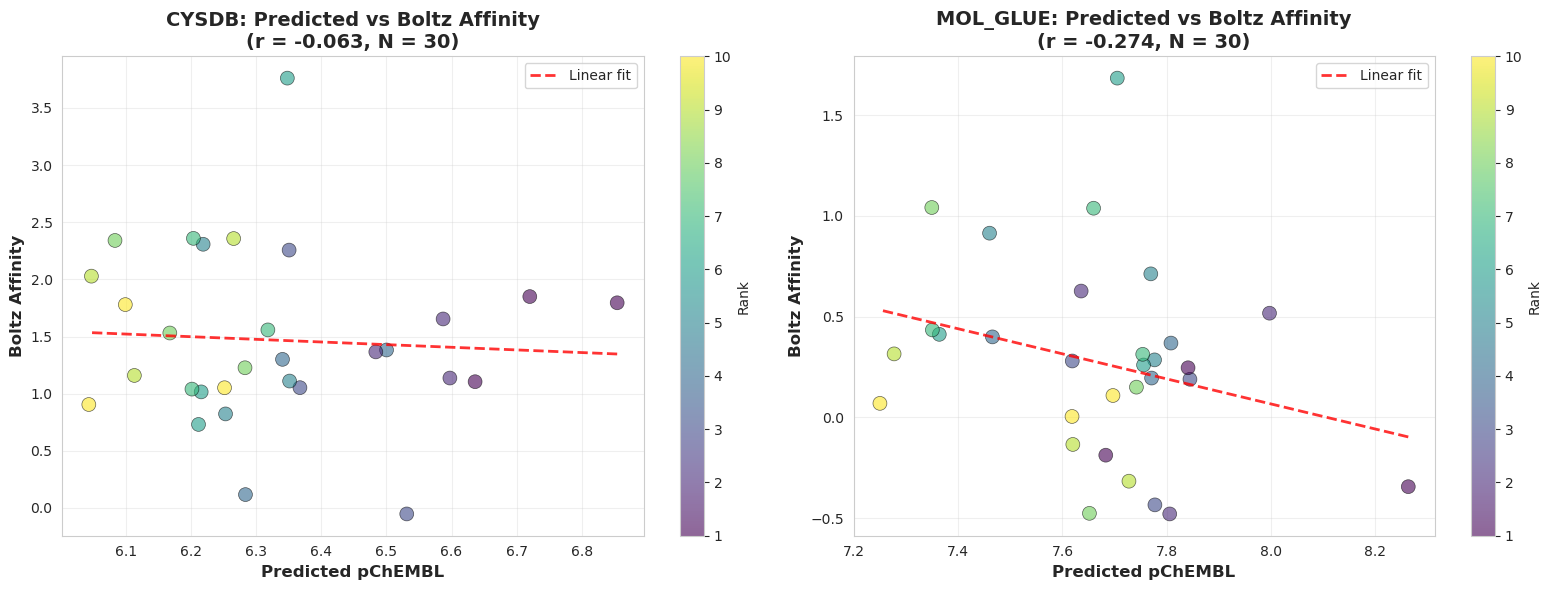

In [7]:
# Scatter plot: Predicted pChEMBL vs Boltz Affinity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, dataset in enumerate(['cysdb', 'mol_glue']):
    subset = merged_results[merged_results['Dataset'] == dataset].dropna(
        subset=['Predicted pChEMBL', 'Boltz_Affinity']
    )
    
    ax = axes[idx]
    scatter = ax.scatter(
        subset['Predicted pChEMBL'], 
        subset['Boltz_Affinity'],
        c=subset['Rank'], 
        cmap='viridis', 
        s=100, 
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add regression line
    if len(subset) > 1:
        z = np.polyfit(subset['Predicted pChEMBL'], subset['Boltz_Affinity'], 1)
        p = np.poly1d(z)
        ax.plot(subset['Predicted pChEMBL'], p(subset['Predicted pChEMBL']), 
                "r--", alpha=0.8, linewidth=2, label=f'Linear fit')
    
    # Calculate correlation
    corr = subset['Predicted pChEMBL'].corr(subset['Boltz_Affinity'])
    
    ax.set_xlabel('Predicted pChEMBL', fontsize=12, fontweight='bold')
    ax.set_ylabel('Boltz Affinity', fontsize=12, fontweight='bold')
    ax.set_title(f'{dataset.upper()}: Predicted vs Boltz Affinity\n(r = {corr:.3f}, N = {len(subset)})', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Rank', fontsize=10)

plt.tight_layout()
plt.savefig('boltz_affinity_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Rank Analysis

Compare how ranks based on predicted pChEMBL vs Boltz affinity differ.

In [ ]:
# Calculate Boltz-based ranks within each protein
merged_results['Boltz_Rank'] = merged_results.groupby(['Protein_ID', 'Dataset'])['Boltz_Affinity'].rank(
    ascending=True, method='dense'
).astype('Int64')  # Use Int64 to handle NaN

# Calculate rank difference
merged_results['Rank_Difference'] = merged_results['Rank'] - merged_results['Boltz_Rank']

# Display rank comparison for each protein-dataset combination
print("Rank Comparison (Predicted vs Boltz):")
print("=" * 80)

for dataset in ['cysdb', 'mol_glue']:
    print(f"\n{dataset.upper()}:")
    subset = merged_results[merged_results['Dataset'] == dataset].dropna(subset=['Boltz_Rank'])
    
    for protein in subset['Protein_ID'].unique():
        protein_subset = subset[subset['Protein_ID'] == protein].sort_values('Rank')
        print(f"\n  Protein: {protein}")
        print(f"  {'Rank':<6} {'Pred pChEMBL':<15} {'Boltz Aff':<15} {'Boltz Rank':<12} {'Difference':<12}")
        print(f"  {'-'*70}")
        
        for _, row in protein_subset.iterrows():
            print(f"  {row['Rank']:<6} {row['Predicted pChEMBL']:<15.3f} "
                  f"{row['Boltz_Affinity']:<15.3f} {row['Boltz_Rank']:<12} "
                  f"{row['Rank_Difference']:<12}")

## 8. Heatmap: Affinity by Protein and Rank

Visualize affinity patterns across proteins and ranks.

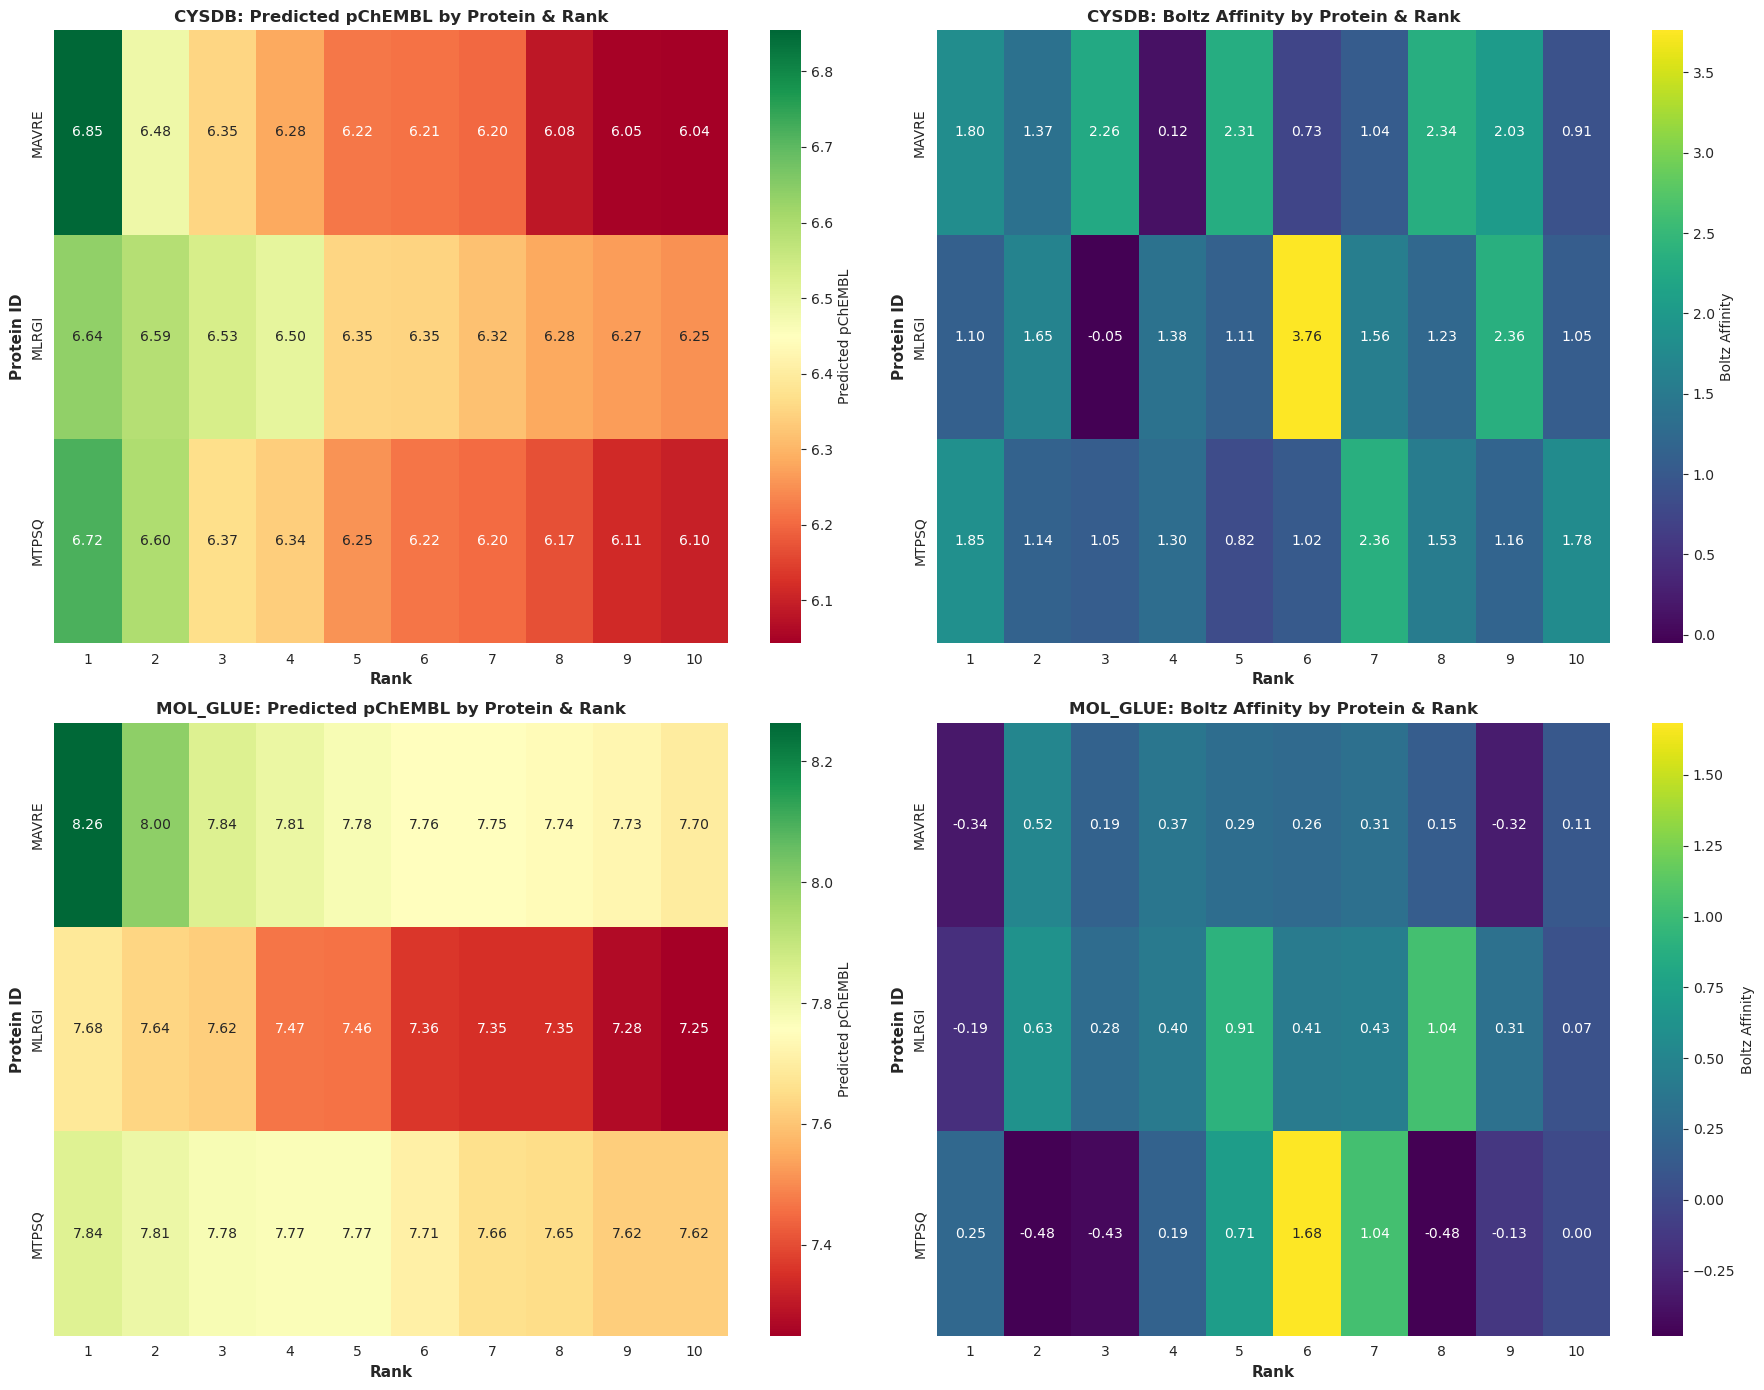

In [8]:
# Create pivot tables for heatmaps
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

for idx, dataset in enumerate(['cysdb', 'mol_glue']):
    subset = merged_results[merged_results['Dataset'] == dataset]
    
    # Predicted pChEMBL heatmap
    pivot_pred = subset.pivot_table(
        values='Predicted pChEMBL', 
        index='Protein_ID', 
        columns='Rank'
    )
    
    sns.heatmap(pivot_pred, annot=True, fmt='.2f', cmap='RdYlGn', 
                ax=axes[idx, 0], cbar_kws={'label': 'Predicted pChEMBL'})
    axes[idx, 0].set_title(f'{dataset.upper()}: Predicted pChEMBL by Protein & Rank', 
                           fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Rank', fontsize=11, fontweight='bold')
    axes[idx, 0].set_ylabel('Protein ID', fontsize=11, fontweight='bold')
    
    # Boltz Affinity heatmap
    pivot_boltz = subset.pivot_table(
        values='Boltz_Affinity', 
        index='Protein_ID', 
        columns='Rank'
    )
    
    sns.heatmap(pivot_boltz, annot=True, fmt='.2f', cmap='viridis', 
                ax=axes[idx, 1], cbar_kws={'label': 'Boltz Affinity'})
    axes[idx, 1].set_title(f'{dataset.upper()}: Boltz Affinity by Protein & Rank', 
                           fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Rank', fontsize=11, fontweight='bold')
    axes[idx, 1].set_ylabel('Protein ID', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('boltz_affinity_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Top Candidates Analysis

Identify the best candidates based on different criteria.

In [9]:
# Top candidates by Boltz affinity (lower is better for binding)
print("TOP 10 CANDIDATES BY BOLTZ AFFINITY (Lower is Better)")
print("=" * 100)

top_boltz = merged_results.dropna(subset=['Boltz_Affinity']).nsmallest(10, 'Boltz_Affinity')
print(top_boltz[['Dataset', 'Protein_ID', 'Rank', 'SMILES', 'Predicted pChEMBL', 
                 'Boltz_Affinity', 'Boltz_Prob_Binary']].to_string(index=False))

print("\n\nTOP 10 CANDIDATES BY PREDICTED pChEMBL (Higher is Better)")
print("=" * 100)

top_pred = merged_results.dropna(subset=['Boltz_Affinity']).nlargest(10, 'Predicted pChEMBL')
print(top_pred[['Dataset', 'Protein_ID', 'Rank', 'SMILES', 'Predicted pChEMBL', 
                'Boltz_Affinity', 'Boltz_Prob_Binary']].to_string(index=False))

print("\n\nCANDIDATES WHERE BOTH METHODS AGREE (Top by both)")
print("=" * 100)

# Normalize both scores to 0-1 scale
valid_results = merged_results.dropna(subset=['Predicted pChEMBL', 'Boltz_Affinity']).copy()
valid_results['Pred_Normalized'] = (valid_results['Predicted pChEMBL'] - valid_results['Predicted pChEMBL'].min()) / \
                                    (valid_results['Predicted pChEMBL'].max() - valid_results['Predicted pChEMBL'].min())
valid_results['Boltz_Normalized'] = 1 - ((valid_results['Boltz_Affinity'] - valid_results['Boltz_Affinity'].min()) / \
                                          (valid_results['Boltz_Affinity'].max() - valid_results['Boltz_Affinity'].min()))

# Combined score (average of normalized scores)
valid_results['Combined_Score'] = (valid_results['Pred_Normalized'] + valid_results['Boltz_Normalized']) / 2

top_combined = valid_results.nlargest(10, 'Combined_Score')
print(top_combined[['Dataset', 'Protein_ID', 'Rank', 'SMILES', 'Predicted pChEMBL', 
                    'Boltz_Affinity', 'Combined_Score']].to_string(index=False))

TOP 10 CANDIDATES BY BOLTZ AFFINITY (Lower is Better)
 Dataset Protein_ID  Rank                                                                                                 SMILES  Predicted pChEMBL  Boltz_Affinity  Boltz_Prob_Binary
mol_glue      MTPSQ     2                                  CC(C)(C)C1=CC=C(NC(=O)NCC2=CC=C3N=NN(C4CCC(=O)NC4=O)C(=O)C3=C2)C=C1Cl           7.805916       -0.479754           0.205016
mol_glue      MTPSQ     8 CC1=C(C)C2=C(S1)N1C(C)=NN=C1[C@H](CC(=O)N(C)C)N=C2C1=CC=C(C2=CC=C(F)C(NC(=O)C3=C4N=CC=CN4N=C3)=C2)C=C1           7.651756       -0.476762           0.142220
mol_glue      MTPSQ     3                             CC(NC(=O)NC1=CC=C(C(C)(C)C)C(Cl)=C1)C1=CC=C2N=NN(C3CCC(=O)NC3=O)C(=O)C2=C1           7.777458       -0.434761           0.174520
mol_glue      MAVRE     1                                   O=C1CCC(N2CC3=C(C=CC(CNC(=O)NC4=CC=CC=C4C4=CC=CC=C4)=C3)C2=O)C(=O)N1           8.263971       -0.344436           0.224072
mol_glue      MAVRE     9      

## 10. Export Results

Save the merged results to CSV for further analysis.

In [10]:
# Save complete results
merged_results.to_csv('boltz_complete_results.csv', index=False)
print("Saved complete results to 'boltz_complete_results.csv'")

# Save top candidates
if 'Combined_Score' in valid_results.columns:
    top_combined.to_csv('boltz_top_candidates.csv', index=False)
    print("Saved top candidates to 'boltz_top_candidates.csv'")

# Display summary
print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print(f"Total protein-compound pairs analyzed: {len(merged_results)}")
print(f"Pairs with Boltz affinity data: {merged_results['Boltz_Affinity'].notna().sum()}")
print(f"Datasets: {merged_results['Dataset'].unique()}")
print(f"Proteins: {merged_results['Protein_ID'].unique()}")
print(f"\nFiles generated:")
print("  - boltz_complete_results.csv")
print("  - boltz_top_candidates.csv")
print("  - boltz_affinity_correlation.png")
print("  - boltz_affinity_heatmaps.png")

Saved complete results to 'boltz_complete_results.csv'
Saved top candidates to 'boltz_top_candidates.csv'

ANALYSIS COMPLETE
Total protein-compound pairs analyzed: 60
Pairs with Boltz affinity data: 60
Datasets: ['cysdb' 'mol_glue']
Proteins: ['MAVRE' 'MTPSQ' 'MLRGI']

Files generated:
  - boltz_complete_results.csv
  - boltz_top_candidates.csv
  - boltz_affinity_correlation.png
  - boltz_affinity_heatmaps.png
